#**Installing the Packages**

In [ ]:
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**🚨 Restart the Run Time**

#**Importing all the required libraries**

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (DetectionMetrics_050,DetectionMetrics_075,DetectionMetrics_050_095)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.utils.distributed_training_utils import setup_device
from super_gradients.training import models

The console stream is logged into C:\Users\Usuario\sg_logs\console.log


[2024-10-05 23:34:35] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-10-05 23:34:35] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-10-05 23:34:36] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.


[WARNING]No module named 'pycocotools'


[2024-10-05 23:34:41] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-10-05 23:34:41] WARNING - export.py - Failed to import pytorch_quantization
[2024-10-05 23:34:41] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-10-05 23:34:41] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


#**Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [24]:
CHECKPOINT_DIR = 'Documents/Entrenamiento04'
setup_device(num_gpus=-1)

trainer = Trainer(experiment_name='entrenamiento_yolo_nas', ckpt_root_dir=CHECKPOINT_DIR)

#**Load your dataset parameters into a dictionary**

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [6]:
dataset_params = {
    'data_dir':'tesis-2',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Base','Cuvette','Matraz','Matraz3B','Pipeta','Vaso','Vial']
}


#**Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 662/662 [00:04<00:00, 148.06it/s]


#**Instantiating the model**


You saw how to instantiate the model for inference earlier. 

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [12]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_s'

In [14]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   ).to(DEVICE)

[2024-08-23 12:29:59] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-08-23 12:29:59] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-08-23 12:29:59] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


#**Define metrics and training parameters**


We need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that we must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 


In [15]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Training the model**

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model 

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [21]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2024-08-23 11:19:53] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240823_111953_432055`
[2024-08-23 11:19:53] INFO - sg_trainer.py - Checkpoints directory: Documents/Entrenamiento04\entrenamiento_yolo_nas\RUN_20240823_111953_432055


The console stream is now moved to Documents/Entrenamiento04\entrenamiento_yolo_nas\RUN_20240823_111953_432055/console_Aug23_11_19_53.txt


[2024-08-23 11:19:54] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-08-23 11:20:16] INFO - sg_trainer_ut

[2024-08-23 12:20:08] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


#**Get the best trained model**

In [7]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/Documents/Entrenamiento04/entrenamiento_yolo_nas/RUN_20240823_111953_432055/ckpt_best.pth")

[2024-10-05 23:35:27] INFO - checkpoint_utils.py - Successfully loaded model weights from C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/Documents/Entrenamiento04/entrenamiento_yolo_nas/RUN_20240823_111953_432055/ckpt_best.pth EMA checkpoint.


#**Evaluating the best trained model on the test set**

In [25]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 42/42 [00:21<00:00,  4.07it/s]

{'Precision@0.50': 0.08045092970132828,
 'Recall@0.50': 0.9945165514945984,
 'mAP@0.50': 0.9545344114303589,
 'F1@0.50': 0.14820311963558197,
 'Best_score_threshold': 0.5299999713897705}

Testing: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


In [51]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=[DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=500, 
                                                   include_classwise_ap = True,
                                                   class_names=['Base','Cuvette','Matraz','Matraz3B','Pipeta','Vaso','Vial'],
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ),
                                DetectionMetrics_075(score_thres=0.1, 
                                                   top_k_predictions=500, 
                                                   include_classwise_ap = True,
                                                   class_names=['Base','Cuvette','Matraz','Matraz3B','Pipeta','Vaso','Vial'],
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ),
                                DetectionMetrics_050_095(score_thres=0.1, 
                                                   top_k_predictions=500, 
                                                   include_classwise_ap = True,
                                                   class_names=['Base','Cuvette','Matraz','Matraz3B','Pipeta','Vaso','Vial'],
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  )
                                
                                ]),


Testing: 100%|██████████| 42/42 [01:05<00:00,  1.56s/it]


({'Precision@0.50': 0.08045092970132828,
  'Recall@0.50': 0.9945165514945984,
  'mAP@0.50': 0.9545344114303589,
  'F1@0.50': 0.14820311963558197,
  'AP@0.50_Base': 0.9652906656265259,
  'AP@0.50_Cuvette': 0.9539899230003357,
  'AP@0.50_Matraz': 0.9642111659049988,
  'AP@0.50_Matraz3B': 0.9865304231643677,
  'AP@0.50_Pipeta': 0.9446676969528198,
  'AP@0.50_Vaso': 0.9812893271446228,
  'AP@0.50_Vial': 0.8857620358467102,
  'Best_score_threshold': 0.06448838859796524,
  'Best_score_threshold_Base': 0.7935704588890076,
  'Best_score_threshold_Cuvette': 0.7022879719734192,
  'Best_score_threshold_Matraz': 0.11877243965864182,
  'Best_score_threshold_Matraz3B': 0.7731293439865112,
  'Best_score_threshold_Pipeta': 0.6842089891433716,
  'Best_score_threshold_Vaso': 0.7146356105804443,
  'Best_score_threshold_Vial': 0.7352226972579956,
  'Precision@0.75': 0.07691918313503265,
  'Recall@0.75': 0.9471108317375183,
  'mAP@0.75': 0.8646211624145508,
  'F1@0.75': 0.14167092740535736,
  'AP@0.75_Base

#**Predicting with the best model**



[2024-08-23 12:37:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


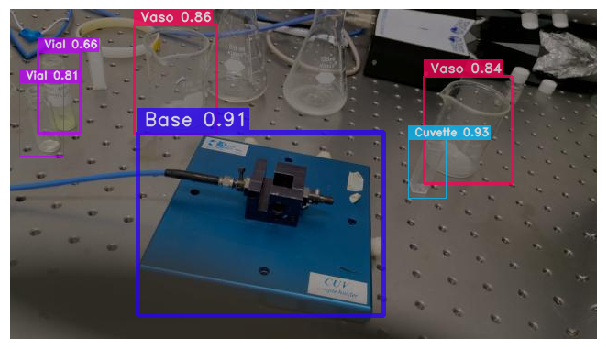

In [28]:
img_url = 'C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/test/images/3a9b56b6-2024-02-26-123209_aug_out_6_png.rf.df7899a9d7f6a8f5f11326e25d2a23b6.jpg'
best_model.predict(img_url).show()

In [30]:
!pip install -q supervision

In [29]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/test/images",
    annotations_directory_path=f"C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/test/labels",
    data_yaml_path=f"C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/data.yaml",
    force_masks=False
)

In [41]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.80

predictions = {}

for image_name, image in ds.images.items():
    result = best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-08-23 12:43:15] INFO -

In [31]:
import random
random.seed(5)

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


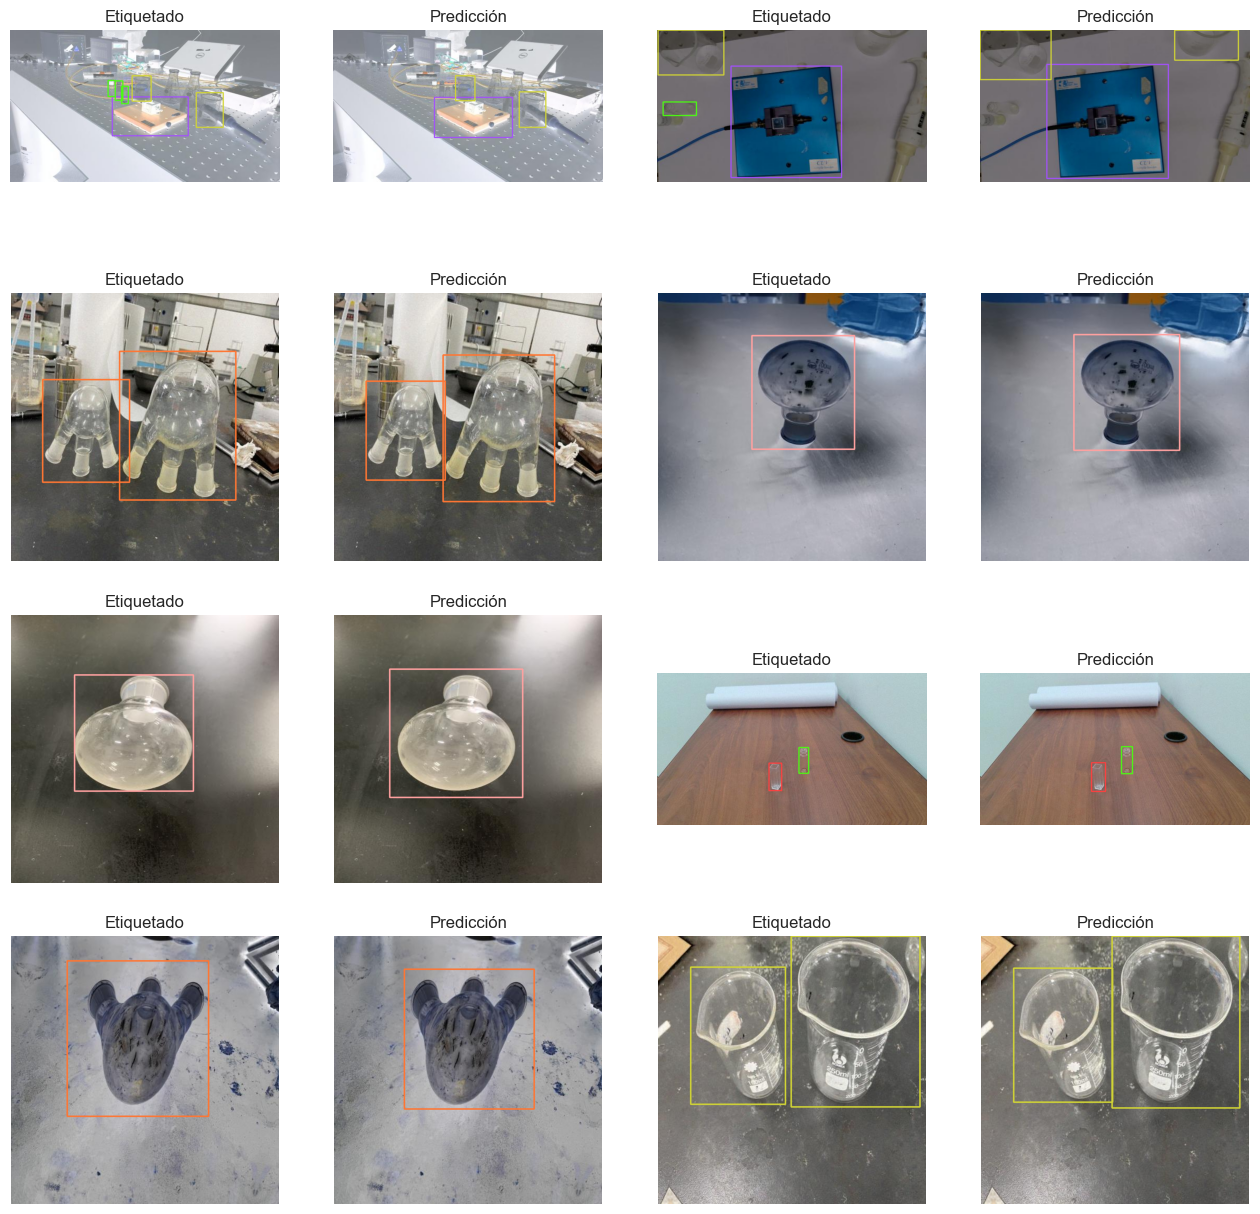

In [45]:
import supervision as sv


MAX_IMAGE_COUNT = 8

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('Etiquetado')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('Predicción')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(4, 4), size=(4 * 4, n * 2))

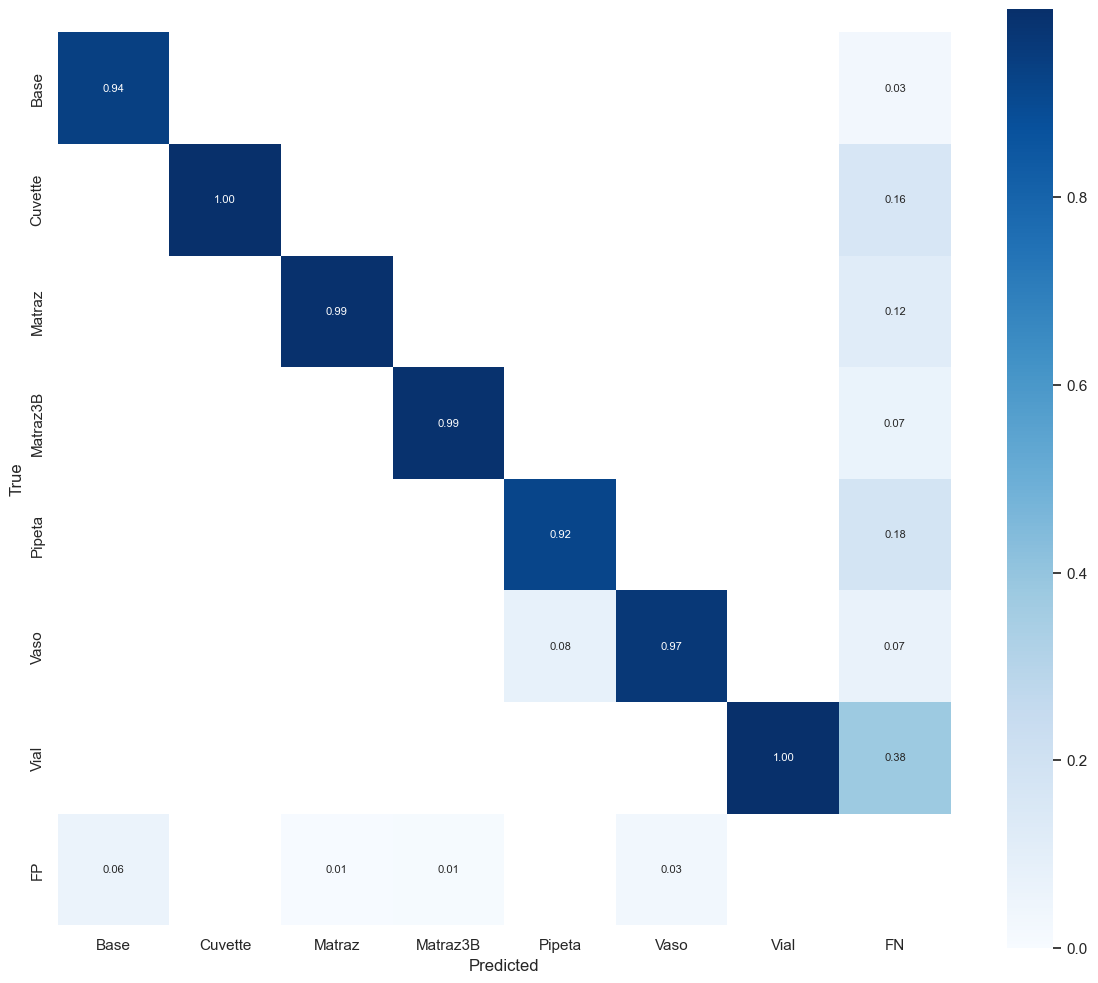

In [47]:
import os
import numpy as np
from onemetric.cv.object_detection import ConfusionMatrix

CONFIDENCE_TRESHOLD = .75

keys = list(ds.images.keys())
annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))

    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join("C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/", "confusion_matrix.png"), class_names=ds.classes)

#**Testing on Video 1**

In [8]:
from super_gradients.common.object_names import Models
from super_gradients.training import models

# Define New Label Names
cNames = ['Base','Cuvette','Flask','Flask3B','Pipette','Beaker','Vial']

best_model.set_dataset_processing_params(
    class_names = cNames,
)


In [13]:
input_video_path = "C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/video/inputVideo/inputVideo01.mp4"
output_video_path = "C:/Users/Usuario/Documents/TesisDataAugmentation/SistemaDUE/tesis-1/video/detectionVideo/detections01Eng_.mp4"


In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path,conf=0.75, fuse_model=False).save(output_video_path)